In [4]:
import sentiment as sentimentinterface
import classify
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline

import importlib

In [5]:
importlib.reload(sentimentinterface)
print("Reading data")
tarfname = "data/sentiment.tar.gz"
sentiment = sentimentinterface.read_data(tarfname)

Reading data
-- train data
sentiment/train.tsv
4582
-- dev data
sentiment/dev.tsv
458
-- transforming data and labels


In [6]:
sentiment.stop_words = sentimentinterface.generate_stop_words(sentiment, diff = 0.4)

from sklearn.feature_extraction.text import CountVectorizer

sentiment.cv = CountVectorizer(min_df = 3)
sentiment.cv.fit_transform(sentiment.train_data)
sentiment.mindf_stop_words = sentiment.cv.stop_words_
sentiment.cv = CountVectorizer(max_df = 0.2)
sentiment.cv.fit_transform(sentiment.train_data)
sentiment.maxdf_stop_words = sentiment.cv.stop_words_
sentiment.cv = CountVectorizer()
sentiment.cv.fit_transform(sentiment.train_data)
sentiment.training_set_vocabulary = sentiment.cv.vocabulary_

sentimentinterface.vectorize_data(sentiment, stop_words = sentiment.stop_words, max_df = 0.2, min_df = 3)
cls = classify.train_classifier(sentiment.trainX, sentiment.trainy, C = 3.7)

classify.evaluate(sentiment.devX, sentiment.devy, cls, 'dev')
# print("\nReading unlabeled data")
# unlabeled = sentimentinterface.read_unlabeled(tarfname, sentiment)
# print("Writing predictions to a file")
# sentimentinterface.write_pred_kaggle_file(unlabeled, cls, "data/sentiment-pred.csv", sentiment)

  Accuracy on dev is: 0.8187772925764192


0.8187772925764192

### Now cls is the optimized model

In [7]:
sentence = 'i hate this place, it tastes like minwoo'

In [8]:
def vectorize_sentence(sentence, count_vect = sentiment.count_vect):
    return count_vect.transform([sentence])

In [9]:
veccc = vectorize_sentence(sentence)

In [10]:
print(veccc)

  (0, 850)	1.0


In [11]:
sentiment.count_vect.get_feature_names()[850]

'hate'

In [27]:
def predict(sentence, cls = cls):
    sentence_vect = vectorize_sentence(sentence)
    result = cls.predict(sentence_vect)
    if result[0] == 0:
        res = "Prediction: NEGATIVE"
    else:
        res = "Prediction: POSITIVE"
    print(res)
    return res

In [13]:
sentence = "Went last night for the first time with my boyfriend. Let me start off by saying I'm vegetarian, but my boyfriend is not. I ordered the chicken v mushroom, it"
print(predict(sentence))

Prediction: NEGATIVE


### Now explain why it predicted 0

#### clean function

In [14]:
def clean(s):
    from string import punctuation
    s_new = []
    s_ignored = []
    res = []
    for c in s:
        if c not in punctuation:
            s_new.append(c.lower())
        else:
            s_new.append(' ')
            
    s = ''.join(c for c in s_new)
    #s = [''.join(c for c in s if c not in punctuation)][0]

    l = s.split()

    for w in l:
        if w in sentiment.count_vect.vocabulary_:
            if w not in res:
                res.append(w)
        else:
            s_ignored.append(w)
#     l = [w for w in l if w in sentiment.count_vect.vocabulary_]

    return res, s_ignored

#### find stop_words

In [43]:
def find_stop_words(s_ignored):
#     sentence_vect = clean(sentence)
    unseen = []
    maxdf = []
    mindf = []
    oliver_algorithm = []
    for w in s_ignored:
        if w not in sentiment.training_set_vocabulary:
            unseen.append(w)
        if w in sentiment.maxdf_stop_words:
            maxdf.append(w)
        if w in sentiment.mindf_stop_words:
            mindf.append(w)
        if w in sentiment.stop_words:
            oliver_algorithm.append(w)
            
#     print("Words being ignored due to not appearing in training set are: ")
    res = "Words being ignored due to not appearing in training set are: \n"
    if len(unseen) == 0:
#         print("None\n")
        res += "None\n"
    else:
#         print(unseen)
#         print('')
        res += '['
        for w in unseen:
            if w == unseen[-1]:
                res += w
            else:
                res += w + ', '
        res += ']\n'
        
#     print("Words being ignored due to mindf (unfrequent in corpus) are: ")
    res += "Words being ignored due to mindf (unfrequent in corpus) are: \n"
    if len(mindf) == 0:
#         print("None\n")
        res += "None\n"
    else:
#         print(mindf)
#         print('')
        res += '['
        for w in mindf:
            if w == mindf[-1]:
                res += w
            else:
                res += w + ', '
        res += ']\n'
        
#     print("Words being ignored due to maxdf (too frequent in corpus) are: ")
    res += "Words being ignored due to maxdf (too frequent in corpus) are: \n"
    if len(maxdf) == 0:
#         print("None\n")
        res += "None\n"
    else:
#         print(maxdf)
#         print('')
        res += '['
        for w in maxdf:
            if w == maxdf[-1]:
                res += w
            else:
                res += w + ', '
        res += ']\n'
        
#     print("Words being ignored due to our algorithm are: ")
    res += "Words being ignored due to our algorithm are: \n"
    if len(oliver_algorithm) == 0:
#         print("None\n")
        res += "None\n"
    else:
#         print(oliver_algorithm)
#         print('')
        res += '['
        for w in oliver_algorithm:
            if w == oliver_algorithm[-1]:
                res += w
            else:
                res += w + ', '
        res += ']\n'
    return res


#### find coef

#### Explain the coef

In [30]:
def explain_coef():
    p_dict = {}
    n_dict = {}
    sentences = sentiment.count_vect.inverse_transform(sentiment.trainX)
    for counter in range(0, len(sentiment.train_labels)):
        if sentiment.train_labels[counter] == "POSITIVE":
            for w in sentences[counter]:
                if w in p_dict:
                    p_dict[w] += 1
                else:
                    p_dict[w] = 1
        else:
            for w in sentences[counter]:
                if w in n_dict:
                    n_dict[w] += 1
                else:
                    n_dict[w] = 1
    return p_dict, n_dict

In [29]:
def find_coef(sentence_vect, tfidf_vect, stop_words = sentiment.stop_words, cls = cls, sentiment = sentiment):
    p_dict,n_dict = explain_coef()
    import pandas as pd
#     sentence_vect = clean(sentence)
    word_list = []
    coef_list = []
    num_p_list = []
    num_n_list = []
    tfidf_list = []
    count_list = []
    contribution_list = []
    for word in sentence_vect:
        if word in sentiment.count_vect.vocabulary_:
#             print(word,"\'s coef:\n", cls.coef_[0][sentiment.count_vect.vocabulary_[word]])
            word_list.append(word)
            coef = cls.coef_[0][sentiment.count_vect.vocabulary_[word]]
            coef_list.append(coef)
            tfidf = tfidf_vect.toarray()[0][sentiment.count_vect.vocabulary_[word]]
            tfidf_list.append(tfidf)
            contribution_list.append(coef*tfidf)
            vec = sentiment.cv.transform([sentence])
            count_list.append(vec.toarray()[0][sentiment.training_set_vocabulary[word]])
            if word in p_dict:
                num_p = p_dict[word]
            else:
                num_p = 0
            if word in n_dict:
                num_n = n_dict[word]
            else:
                num_n = 0
#             print("Number of ",word,"in POSITIVE reviews: ",num_p,"\tNumber of ",word,"in NEGATIVE reviews: ",num_n,"\n")
            num_p_list.append(num_p)
            num_n_list.append(num_n)
    dic = {'Feature':word_list, 'Coef':coef_list, 'in POSITIVE':num_p_list,
          'in NEGATIVE':num_n_list, 'tfidf val':tfidf_list, 'Original Count':count_list,
          'Contribution':contribution_list}
    df = pd.DataFrame(dic)
    df = df[['Feature','Contribution','Original Count','tfidf val','Coef','in POSITIVE','in NEGATIVE']]
#     print(df)
    return df

In [18]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    try:
        if float(val) < 0:
            color = 'red'
        elif float(val) > 0:
            color = 'green'
        else:
            color = 'black'
#         color = 'red' if float(val) < 0 else 'black'
    except ValueError:
        color = 'black'

    return 'color: %s' % color

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

In [39]:
def analysis(sentence):
    sentence_vect, s_ignored = clean(sentence)
    tfidf_vect = sentiment.count_vect.transform([sentence])
    res = find_stop_words(s_ignored)
    res += "Remaining words in the vec: \n["
    for w in sentence_vect:
        if w == sentence_vect[-1]:
            res += w
        else:
            res += w + ', '
    res += ']\n'
    print(res)
#     print("Remaining words in the vec:")
#     print(sentence_vect)
    df = find_coef(sentence_vect, tfidf_vect)
    df = df.style.applymap(color_negative_red, subset=['Coef','Contribution']).\
        apply(highlight_max, subset=['Coef','Contribution']).\
        apply(highlight_min, subset=['Coef','Contribution'])
#     df = df.style.apply(highlight_max)
    return df,res

### Visualization 

In [20]:
import copy
import math
import matplotlib as mpl

# Logistic Regression Interception
intercept = copy.deepcopy(cls.intercept_)[0]

# Vectorizer vocaulary list (ordered)
cv = sentiment.count_vect.vocabulary_
cv = [(v,w) for w,v in cv.items()]
cv.sort()
cv = [x[1] for x in cv]

def bar_chart(cd, title='',ylabel=''):
    
    words = [w for w,_ in cd.items()]
    coefs = [cd[w] for w in words]
    l = [x for x in zip(coefs, words)]
    l.sort()
    words = [w for c,w in l]
    coefs = [c for c,w in l]

    fig = plt.figure(figsize=(10,5))
    colors = ['red' if c < 0 else 'blue' for c in coefs]
    plt.bar(words, coefs, color=colors)
    plt.xlabel('Word', fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(fontsize=20, rotation=30)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize = 30)
    plt.show()
    
    return fig

def coef_list(words):
    d = {}
    for w in words:
        c = cls.coef_[0][sentiment.count_vect.vocabulary_[w]]
        d[w] = c
        
    return d

def tfidf_x_coef(x):
    
    cd = {}
    for i,v in zip(x.indices, x.data):
        cd[cv[i]] = cls.coef_[0][i] * v
        
    return cd

def prob(x):
    
    z = intercept
    for i,v in zip(x.indices, x.data):
        z += cls.coef_[0][i] * v
        
    pos = 1 / (1 + math.exp(-z))
    neg = 1 - pos
    
    return [neg,pos]

def pie_chart(probs):
    
    mpl.rcParams['font.size'] = 20
    
    fig = plt.figure(figsize=(5,5))
    labels = ["Negative", "Positive"]
    colors = ['red', 'blue']
    explode = (0.1, 0)
    plt.pie(probs, labels=labels, colors=colors,shadow=True, explode=explode,
            autopct='%1.1f%%', startangle=-30)
    plt.axis('equal')
    plt.show()
    
    return fig

def generate_graphs(sentence):
    
    figs = []
    x,y = clean(sentence)
    
    x_vec = sentiment.count_vect.transform([sentence])
    probs = prob(x_vec)
    f3 = pie_chart(probs)
    figs.append(f3)
    
    cd = coef_list(x)
    f1 = bar_chart(cd, 'Words with Coefficients', 'Coefficient')
    figs.append(f1)

    
    cd = tfidf_x_coef(x_vec)
    f2 = bar_chart(cd, 'Words with Tfidfs * Coefficients', 'Tfidf * Coef')
    figs.append(f2)

    
    
    return figs

### Usage

good example:
    TN:  sentiment.train_data[199]
    

In [45]:
sentence = sentiment.train_data[697]

In [46]:
sentence

"Pretty darn good. Went here for a pre-laser tag lunch and beer. First off, the server had an excellently groomed 'tache. Nice 'tache bro. Very nice staff who engaged my"

In [48]:
sentiment.trainy[697]

1

In [49]:
predict(sentence)

Prediction: POSITIVE


'Prediction: POSITIVE'

In [50]:
df,res = analysis(sentence)
df

Words being ignored due to not appearing in training set are: 
[a]
Words being ignored due to mindf (unfrequent in corpus) are: 
[excellently, groomed, tache, tache, bro, engaged]
Words being ignored due to maxdf (too frequent in corpus) are: 
[for, and, the, my]
Words being ignored due to our algorithm are: 
[pretty, good, here, for, pre, lunch, and, beer, first, off, the, server, had, an, very, who, my]
Remaining words in the vec: 
[darn, went, laser, tag, nice, staff]



,Feature,Contribution,Original Count,tfidf val,Coef,in POSITIVE,in NEGATIVE
0,darn,-0.149763,1,0.476392,-0.314369,1,2
1,went,-0.274056,1,0.21894,-1.25174,103,205
2,laser,0.664737,1,0.463177,1.43517,4,0
3,tag,0.218288,1,0.476392,0.458211,2,1
4,nice,0.549435,2,0.479745,1.14527,136,80
5,staff,0.141267,1,0.231252,0.610879,170,80


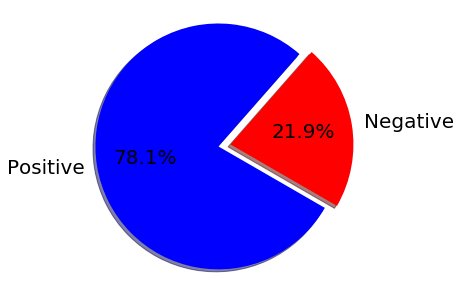

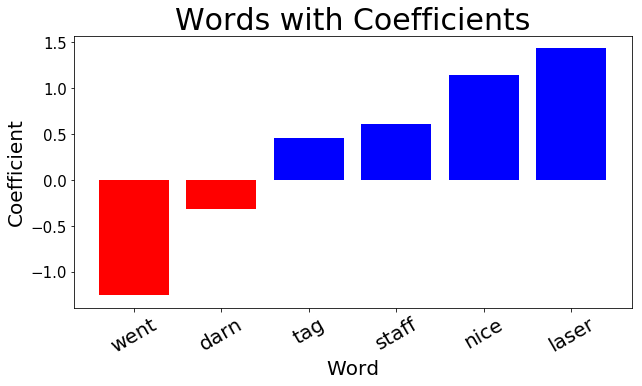

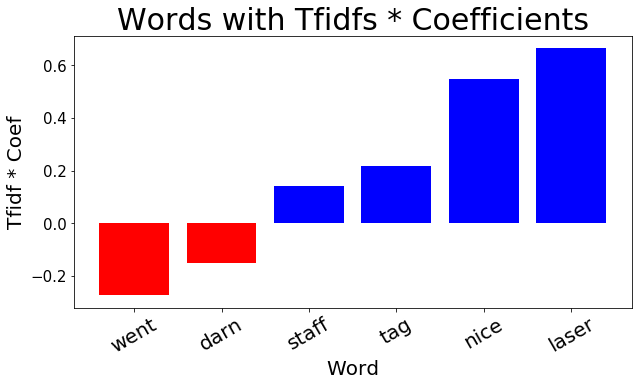

In [51]:
figs = generate_graphs(sentence)

In [29]:
figs

[<Figure size 360x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>]

### Testing Space

In [30]:
sentiment.cv = CountVectorizer(min_df = 3)

In [106]:
len(sentiment.cv.vocabulary_)

9882

In [107]:
sentiment.cv.stop_words_

set()

In [201]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

ImportError: No module named 'seaborn'

In [202]:
!pip install seaborn

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [33]:
figs[0].savefig('3.png')

In [38]:
type(df)

pandas.io.formats.style.Styler

In [37]:
type(df.render())

str

In [40]:
import imgkit
html = df.render()
options = {"xvfb": ""}
imgkit.from_string(html, "7.png", options=options)

process 2056: D-Bus library appears to be incorrectly set up; failed to read machine uuid: UUID file '/etc/machine-id' should contain a hex string of length 32, not length 0, with no other text
See the manual page for dbus-uuidgen to correct this issue.
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

In [4]:
!pip3 install imgkit

  Running setup.py bdist_wheel for imgkit ... done
  Stored in directory: /home/jiajinliang/.cache/pip/wheels/64/34/8e/1719358e8263f9f33217b9f11d1a70d9e122b75afa5732f032
Successfully built imgkit
You are using pip version 8.1.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [34]:
!pip3 install wkhtmltoimage

  Could not find a version that satisfies the requirement wkhtmltoimage (from versions: )
No matching distribution found for wkhtmltoimage
You are using pip version 8.1.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/home/jiajinliang/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.table' is deprecated, import 'pandas.plotting.table' instead.
  """


ValueError: Input data must be DataFrame or Series

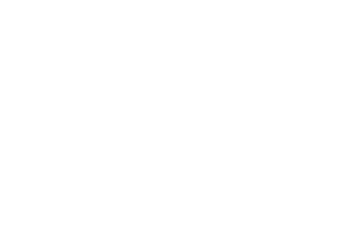

In [36]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
from pandas.tools.plotting import table
table(ax, df)  # where df is your data frame
